##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#What modifications are needed to improve the reconstruction accuracy of the image?
Modifications needed for the reconstruction accuracy of the images in the MNIST dataset are changing the input shapes to the encoder to accept the 32,32 size of the images and add another dimension for the color channels. 

# Convolutional Variational Autoencoder

#CIFAR-10 VAE
Repeat all of the above steps for the cifar10 dataset (except the step "Display a 2D manifold of digits from the latent space"). You should trained your VAE to obtain >90% accuracy on the training dataset.

Please added text heading to each section like the code above. You can create a new notebook for this part.

## Setup

In [ ]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-3jv2z0u1
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-3jv2z0u1
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0a9cbc44121628a60850bb9388282167a93ed26ff_-cp37-none-any.whl size=147327 sha256=6ba5cfdb9489afb7e74412fb2492d64d417c76296d62912c86922bdd2aef59dd
  Stored in directory: /tmp/pip-ephem-wheel-cache-knxutvn1/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [ ]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

from sklearn.decomposition import PCA

# CIFAR-10 VAE

## Load the CIFAR dataset

In [ ]:
(train_images, training_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

In [ ]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 32, 32, 3)) / 255.
  return images.astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [ ]:
train_size = 50000
batch_size = 32
test_size = 10000

#Show one image for each class from the training dataset

In [ ]:
def show_img(c, label):
  class_img = train_images[(training_labels == c).flatten()][0]  
  plt.imshow(class_img)
  plt.title(label)
  plt.show()


In [ ]:
class_labels = ['plane(0)', 'automobile(1)', 'bird(2)', 'cat(3)', 'deer(4)', 'dog(5)', 'frog(6)', 'horse(7)', 'ship(8)', 'truck(9)']
rng = np.arange(0,10)

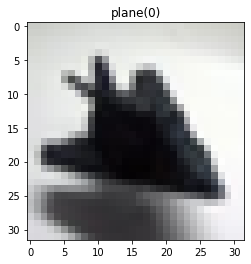

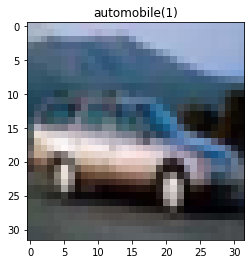

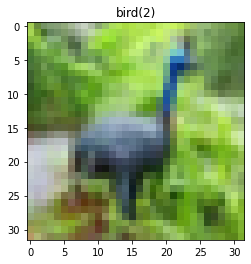

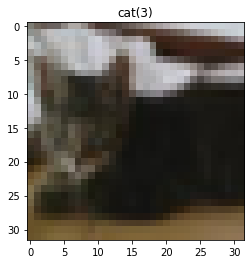

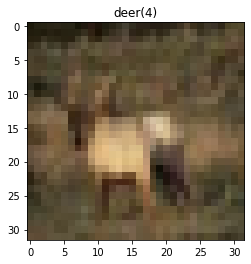

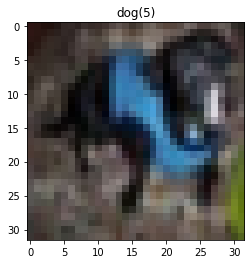

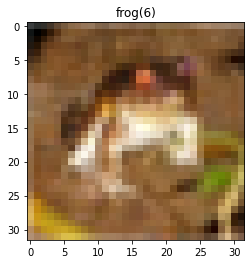

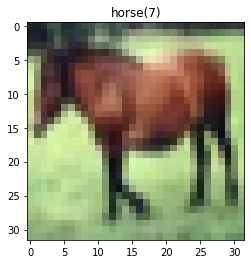

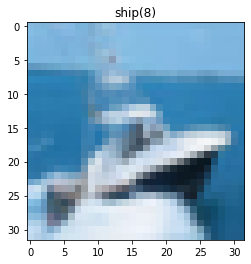

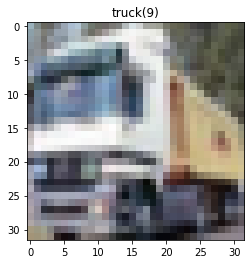

In [ ]:
for i, c in zip(class_labels,rng):
  show_img(c,i)

## Use *tf.data* to batch and shuffle the data

In [ ]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

## Define the encoder and decoder networks with *tf.keras.Sequential*

In our VAE example, we use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively. We use `tf.keras.Sequential` to simplify implementation. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$. 
In this example, we simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. 
We output log-variance instead of the variance directly for numerical stability.

### Decoder network 
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation.
We model the latent distribution prior $p(z)$ as a unit Gaussian.

### Reparameterization trick
To generate a sample $z$ for the decoder during training, we can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, we use a reparameterization trick.
In our example, we approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. We generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
For the encoder network, we use two convolutional layers followed by a fully-connected layer. In the decoder network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.


In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(1, 32, 32, 3)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

## Plot model architecture

#Encoder

Encoder:


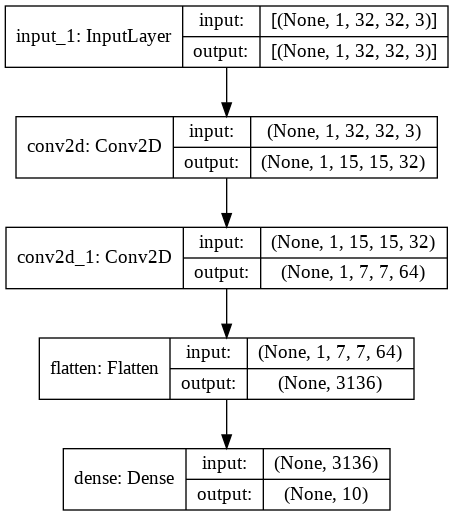

In [ ]:
# Put code here
model = CVAE(5)
print("Encoder:")
tf.keras.utils.plot_model(model.encoder, show_shapes = True, show_layer_names= True)

#Decoder

Decoder:


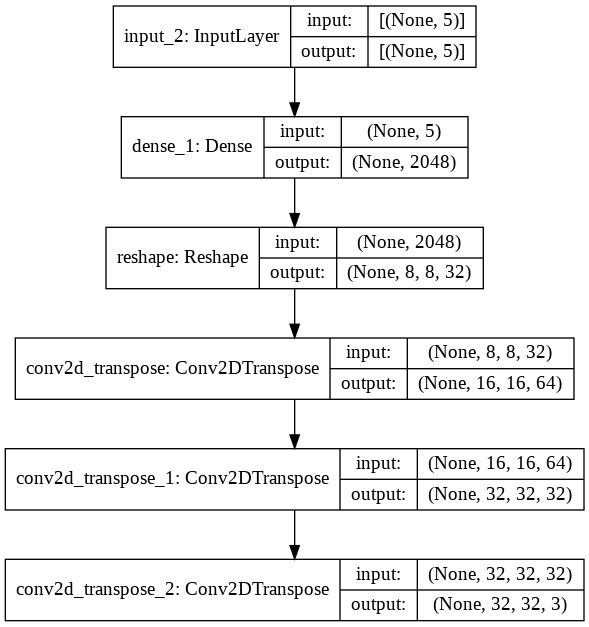

In [ ]:
print("Decoder:")
tf.keras.utils.plot_model(model.decoder, show_shapes = True, show_layer_names= True)

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)
  
def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y, sigma_sqr=1.0):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)
  

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Define accuracy metric
Compute the percentage of element reconstructed with less than e value difference. You need to incorporate this accuracy metric in the training flow. We want to set e = 0.03.

In the function below: 
* model: the model under training
* x: the input images
* e: The tolerable error between the input value and the reconstructed value

In [ ]:
def compute_accuracy(model, x, e=0.03):
    # generate train_z
    mean, logvar = model.encode(x)
    train_z = model.reparameterize(mean, logvar)

    # generate reconstructed images
    x_recon = model.decode(train_z, apply_sigmoid=True)

    # calculate reconstruction accuracy
    accuracy = tf.reduce_sum(tf.cast(tf.abs(x_recon-x) < e, tf.float32))/tf.cast(tf.size(x), tf.float32)

    return accuracy

## Training

* We start by iterating over the dataset
* During each iteration, we pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* We then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, we pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* **Note:** Since we use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

### Generating images

* After training, it is time to generate some images
* We start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here we plot the probabilities of Bernoulli distributions


In [ ]:
#started at 10

epochs = 100
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 128
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, :])
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 100, Test set ELBO: -1820.2015380859375, time elapse for current epoch: 5.16602897644043
tf.Tensor(0.28785285, shape=(), dtype=float32)


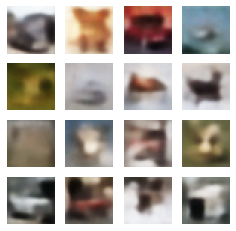

In [ ]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()
  
  acc = 0.0
  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
    acc = acc + compute_accuracy(model, test_x, 0.03)
  
  mean_acc = acc / len(test_dataset)
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  print(mean_acc)
  generate_and_save_images(model, epoch, test_sample)

### Display a generated image from the last training epoch

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

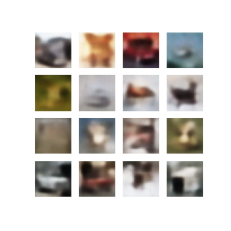

In [ ]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

### Display an animated GIF of all the saved images

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


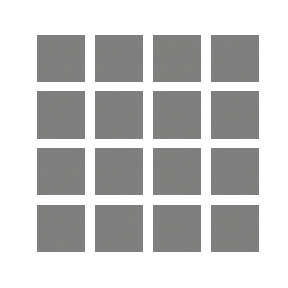

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### Compare the original image with the reconstructed image
Select 16 images and pass them through the trained VAE to obtain the reconstrcued images. Plot the original images on a 4x4 plot and plot the reconstrcued images on another 4x4 plot.

In [ ]:
# Put code here
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  tester_sample = test_batch[0:num_examples_to_generate, :, :, :]

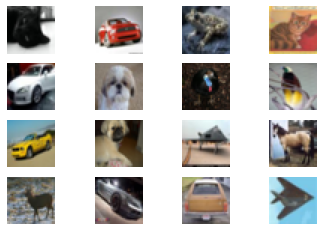

In [ ]:
for i in range(tester_sample.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(tester_sample[i, :, :, :])
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
plt.show()

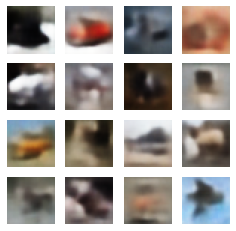

In [ ]:
mean, logvar = model.encode(tester_sample)
z = model.reparameterize(mean, logvar)
predictions = model.sample(z)
fig = plt.figure(figsize=(4, 4))

for i in range(predictions.shape[0]):
  plt.subplot(4, 4, i + 1)
  plt.imshow(predictions[i, :, :, :])
  plt.axis('off')

plt.show()

### Compute the mean image of each class
Encode and reparametrize all training images within a class and compute the meean of all the latent spaces. Decode the latent space mean and plot the decoded image. Do this for all classes. 

The steps are as follow:
* Find all training images belonging to class c
* Encode and reparametrize all the images belonging to class c
* Find the mean of the latent spaces
* Decode the mean of the latent space and plot it

In [ ]:
# define function for plotting the mean image
def plot_mean_image(model, dataset):
  for i in range(10):
    img = dataset[((training_labels == i).flatten())]
    mean, logvar = model.encode(img)
    z = model.reparameterize(mean, logvar)
    latent_mean = tf.math.reduce_mean(z, axis=0)
    latent_mean = tf.reshape(latent_mean, (1,-1))
    x = model.sample(latent_mean)
    plt.imshow(x[0,:,:,:] )
    plt.show()

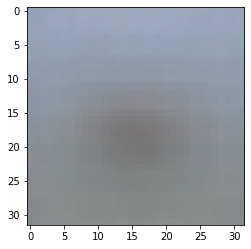

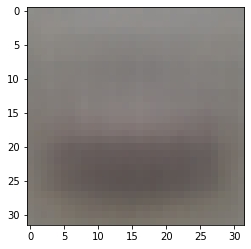

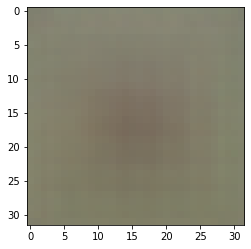

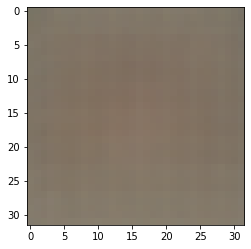

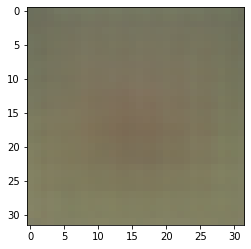

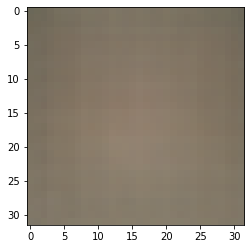

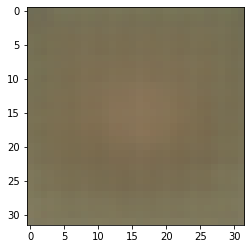

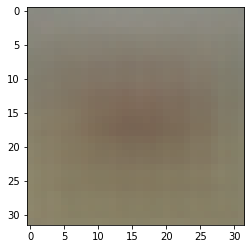

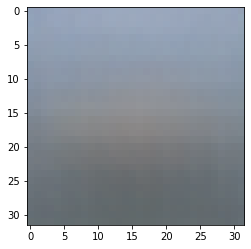

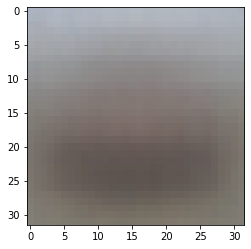

In [ ]:
plot_mean_image(model, train_images)

#Does the "mean image" of each class look similar to the training images within its class? If not, explain why?

The mean images do not look exactly like the training images because the mean image is composed of multiple samples of different figures as opposed to the MNIST dataset where the figures were all nearly identical digits. These mean images look blurred since they consist of generalized figures for all different planes, automobiles, cats, etc. 


### Visualize the latent space
As mentioned in the beginning of the notebook, VAE maps the input data into the parameters of a probability distribution, such as the mean and variance of a Gaussian. In this part of the homework, we want to visualize the distribution of the data points with respect to their classes in a 2D space. To make the coding easier, we will represent each data point as a single point in their distribution rather than the probability distribution. 

Steps are as follow:
* Select 500 samples from each class
* Encode and reparametrize each sample
* If the latent space of the samples is greater than 2 dimensions, use any dimensional reduction method (such as TSNE, PCA...) to reduce the latent space into 2D
* Plot all the 2D latent space on a scatter plot. Use color and legend to indicate the class of each sample

In [ ]:
tot_sample = []
tot_labels = []

def load_class_sample(c):
  img = train_images[sum(np.asarray(training_labels==c).tolist(), [])]
  tot_sample.append(img[:500])

for i in range(10):
  load_class_sample(i)

for train_batch in train_dataset.take(1):
  train_sample = train_batch[0:500, :, :, :]

np_tot = np.asarray(tot_sample)
np_tot = np.vstack(tot_sample)
samp_labels = np.arange(10)
samp_labels = np.repeat(samp_labels,500, axis = 0)

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    mean, logvar = model.encode(data)
    z = model.reparameterize(mean, logvar)
    plt.figure(figsize=(12, 10))
    plt.scatter(z[:, 0], z[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

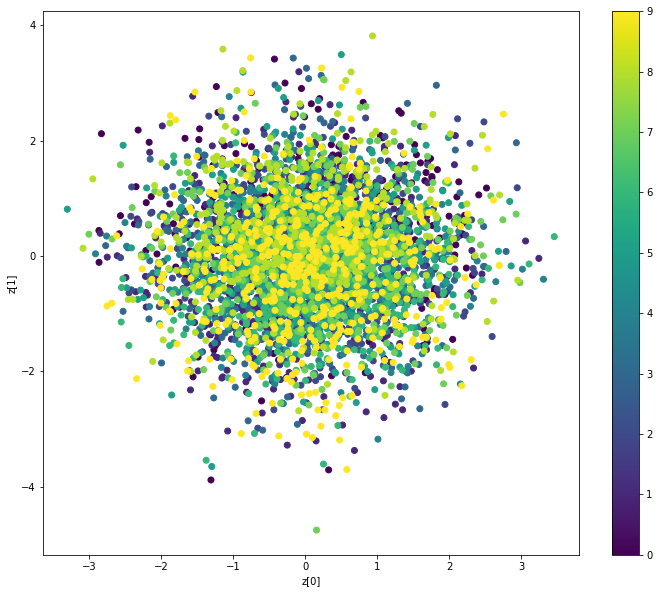

In [ ]:
plot_label_clusters(model, np_tot, samp_labels)

#Visualize the latent space. Is there a clear boundary between the classes? Explain. (hint: lower dimensional projection)

There is not a clear boundary between the classes in the 2D dimensional projection and there needs to be a separate dimension so that the clusters can be visibly separated from each other. 

### Walk from one class to another
Visualize how the information changes when you walk from one number's latent space to another. The steps are as follow:


*   Encode and reparametrize both the source image and destination image to obtain two latent spaces. (Use trained encoder and reparametrize)
*   Compute the direction from the source latent space to the destination latent space.
*   Take 15 incremental step to go from the source latent space to the destination latent space. At every step, you should decode the latent space to an image to visualize the change in information. (Use trained decoder)
*   You should end up 16 images: 1 source image, 1 destination image and 14 in-between images. Plot these images on a 4x4 plot.
*   Visualize the morphing between these sets of number: {1 -> 5}, {8 -> 3}, {9 -> 2}



In [ ]:
decoded_imgs = []

In [ ]:
# define morphing function
def walk_src_to_dst(model, src, dst):
  mean, logvar = model.encode(src)
  z_src = model.reparameterize(mean, logvar)
  mean, logvar = model.encode(dst)
  z_dst = model.reparameterize(mean, logvar)
  
  #calculate step mean prob from src to dst
  step = (z_dst - z_src) / 15
  current_step = 0
  decoded_imgs = []
  for i in range(16):
    decoded = model.decode(z_src+current_step, apply_sigmoid=True)
    current_step = step + current_step
    #print(current_step)
    decoded_imgs.append(decoded)
  fig,axs = plt.subplots(4,4)
  decoded_imgs = np.reshape(decoded_imgs, (4,4,32,32,3))
  for i in range(4):
    for j in range(4):
      axs[i,j].imshow(decoded_imgs[i][j])

#Walk from one class to another. Describe the morphing process. Is it a "smooth" transition? Explain. (hint: probability distribution) 

From the image plots, it can be observed that the image morphs properly into the destination image provided that the means between the source and destination image are close to each other per step demonstrating closeness within the latent space distribution. 

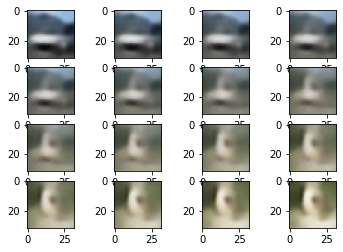

In [ ]:
# morph from 1 to 5
walk_src_to_dst(model, np.expand_dims(tot_sample[1][0], axis = 0), np.expand_dims(tot_sample[5][15], axis = 0))

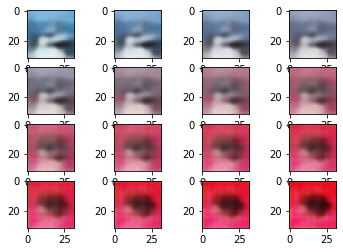

In [ ]:
# morph from 8 to 3
walk_src_to_dst(model, np.expand_dims(tot_sample[8][0], axis = 0), np.expand_dims(tot_sample[3][2], axis = 0))

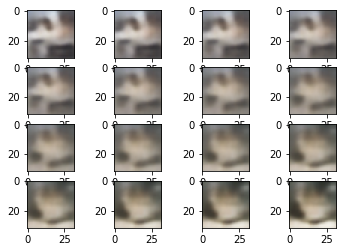

In [ ]:
# morph from 9 to 2
walk_src_to_dst(model, np.expand_dims(tot_sample[9][0], axis = 0), np.expand_dims(tot_sample[2][123], axis = 0))